# Import Modules

In [0]:
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import pandas as pd
import numpy as np
import os
from numpy import asarray
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, classification_report

%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import * 

import keras
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

np.random.seed(1)
tf.set_random_seed(2) #tfv1 set_random_seed, tf v2 set_seed

In [2]:
from tensorflow.python.client import device_lib
if __name__ == "__main__":
    print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1041481370807479008
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 17544140743142019271
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 8077835153445050192
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15956161332
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7586989662523137969
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


# Data Preparation

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
cd /content/drive/My Drive/SemEval_2020

/content/drive/My Drive/SemEval_2020


## Read CSV Data (You can ignore this)

In [0]:
PATH_CSV = "./data_7000_processed.csv" # use pre-processed data, it ignores 26 missing images, actual enties are 6974
PATH_IMG = "./memotion_analysis_training_data/data_7000/"
trainX=[]
data = pd.read_csv(PATH_CSV, index_col=0)  
# data.columns = ['Image_name', 'Image_URL', 'OCR_extracted_text', 'corrected_text',
#        'Humour', 'Sarcasm', 'offensive', 'Motivational', 'humour']
data.shape

(6974, 11)

In [0]:
data.head(20)

,Image_name,Image_URL,OCR_extracted_text,corrected_text,Humour,Sarcasm,offensive,Motivational,Overall_Sentiment,img_width,img_height
0,10_year_10-year-challenge_1547788782.jpeg,https://spiderimg.amarujala.com/assets/images/...,The best of #10 YearChallenge! Completed in le...,The best of #10 YearChallenge! Completed in le...,not_funny,general,not_offensive,motivational,very_positive,749,506
1,10_year_10yearchallenge-5c75f8b946e0fb0001edc7...,https://www.lifewire.com/thmb/8wNfd94_meE9X2cp...,Sam Thorne @Strippin ( Follow Follow Saw every...,Sam Thorne @Strippin ( Follow Follow Saw every...,very_funny,not_sarcastic,not_offensive,not_motivational,positive,766,571
2,10_year_10-year-challenge-sweet-dee-edition-40...,https://pics.conservativememes.com/10-year-cha...,10 Year Challenge - Sweet Dee Edition,10 Year Challenge - Sweet Dee Edition,very_funny,twisted_meaning,very_offensive,motivational,positive,500,334
3,10_year_10-year-challenge-with-no-filter-47-hi...,https://pics.me.me/10-year-challenge-with-no-f...,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,hilarious,very_twisted,very_offensive,not_motivational,neutral,500,429
4,10_year_10-years-challenge.jpg,https://i0.wp.com/beyondblindfold.com/wp-conte...,"What if the ""10 Year Challenge"" was created by...","What if the ""10 Year Challenge"" was created by...",hilarious,general,slight,not_motivational,very_positive,780,399
5,10_year_10-years-challenge-about-humanity_o_72...,https://img.memecdn.com/10-years-challenge-abo...,"1998: ""Don't get in car with strangers"" 2008: ...","1998: ""Don't get in car with strangers"" 2008: ...",hilarious,general,slight,motivational,negative,540,960
6,10_year_10-years-Challenge-Featured-Image.png,https://www.torchindark.co.in/wp-content/uploa...,"<html><head><meta content=""text/html; charset=...",What happened 10 years ago in India,not_funny,twisted_meaning,not_offensive,not_motivational,neutral,1920,1080
7,10_year_10-years-challenge-is-it-af-1945-1955-...,https://pics.me.me/10-years-challenge-is-it-af...,10 years challenge is lit af Üs & B erg 1945 1...,10 years challenge is lit af Üs & B erg 1945 1...,not_funny,not_sarcastic,not_offensive,not_motivational,negative,500,566
8,10_year_13-2.jpg,https://ozzyman.com/wp-content/uploads/2019/01...,10 Year Challenge emotional edition boredpanda...,10 Year Challenge emotional edition boredpanda...,very_funny,twisted_meaning,not_offensive,not_motivational,neutral,700,563
9,10_year_2c2.jpg,https://i.kym-cdn.com/photos/images/original/0...,FBI: We need to start updating our facial reco...,FBI: We need to start updating our facial reco...,very_funny,general,not_offensive,not_motivational,neutral,1242,1141


Show how many pictures in each class

In [0]:
data['Humour'].value_counts() #corrected data

funny         2449
very_funny    2231
not_funny     1646
hilarious      648
Name: Humour, dtype: int64

## Read Image data (You can ignore this)
it may crash Google colab, please import processed pickle files

In [0]:
## use cv2, and delete 2-channel error image
c = 0
size = 128,128  # img size: height, width 
X = [ ]     # creating an empty array
error = []
for img_name in tqdm(data['Image_name']):
  c += 1
#   image = Image.open(PATH_IMG + img_name)
#   img = asarray(image.resize(size))
  if(os.path.isfile(PATH_IMG + img_name)):
    image = cv2.imread((PATH_IMG + img_name), cv2.IMREAD_COLOR)
    if image is not None:
#       pass
      img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      img = cv2.resize(img, size)
      if img.ndim != 3:                  # if the image is not RGB
        img = np.dstack([img, img, img]) # use the same value for the 3 RGB channels
      X.append(img)  # storing each image in array X
    else:
      print('None:{}'.format(img_name))
      error.append(img_name)
  else:
    print('Not Exists:{}'.format(img_name))
    error.append(img_name)
#   print(c,img.shape, img_name) # print each image infomaiton

print(error)
X = np.array(X)   # converting list to array
data = data[~data['Image_name'].isin(error)] # delete data of error images


100%|██████████| 1886/1886 [00:21<00:00, 86.94it/s]

[]


## *Or Import processed data* (use this to import data)

In [0]:
# Import pre-processed image data
import pickle 

data = pickle.load(open("/content/drive/My Drive/SemEval_2020/New_Training_Data/NewData_6988.pickle", "rb"))
X = pickle.load(open("/content/drive/My Drive/SemEval_2020/New_Training_Data/NewTrainX_6988.pickle", "rb")) #import preprocessed 128*128 data


data_trial = pickle.load(open("/content/drive/My Drive/SemEval_2020/New_Training_Data/TrialData_910.pickle", "rb"))
X_trial = pickle.load(open("/content/drive/My Drive/SemEval_2020/New_Training_Data/TrialX_910.pickle", "rb"))

data_test = pickle.load(open("/content/drive/My Drive/SemEval_2020/New_Training_Data/TestData_1877.pickle", "rb"))
X_test = pickle.load(open("/content/drive/My Drive/SemEval_2020/New_Training_Data/TestX_1877.pickle", "rb"))

In [6]:
width, height, channels = X.shape[1:]
print(X.shape)
print(X_trial.shape)
print(X_test.shape)

X = X/255
X_trial = X_trial/255
X_test = X_test/255

(6988, 128, 128, 3)
(910, 128, 128, 3)
(1877, 128, 128, 3)


In [0]:
data = data.reset_index(drop=True)
# Y_3 = np.array(data['overall_sentiment'].replace('very_positive','positive').replace('very_negative','negative'))

In [0]:
# Import pre-processed image data
import pickle 

data = pickle.load(open("/content/drive/My Drive/SemEval_2020/New_Training_Data/NewData.pickle", "rb")) # dataframe 
# error = pickle.load(open("/content/drive/My Drive/SemEval_2020/New_Training_Data/NewError.pickle", "rb"))  # error image
# X = pickle.load(open("/content/drive/My Drive/SemEval_2020/New_Training_Data/NewTrainX.pickle", "rb")) #import preprocessed 128*128 data
# Y_3 = pickle.load(open("/content/drive/My Drive/SemEval_2020/New_Training_Data/NewTrainY_3.pickle", "rb"))  #3-class value
# width, height, channels = X.shape[1:]
# X = X/255

In [10]:
list(data.columns)

['image_name',
 'text_ocr',
 'text_corrected',
 'humour',
 'sarcasm',
 'offensive',
 'motivational',
 'overall_sentiment']

In [42]:
data = data.replace('funny','Humorious').replace('very_funny','Humorious').replace('hilarious','Humorious').replace('not_funny', 'Not humorious')
data_trial = data_trial.replace('funny','Humorious').replace('very_funny','Humorious').replace('hilarious','Humorious').replace('not_funny', 'Not humorious')
data['humour'].value_counts()

Humorious        5337
Not humorious    1651
Name: humour, dtype: int64

In [48]:
data = data.replace('motivational','Motivational').replace('not_motivational','Not motivational')
data_trial = data_trial.replace('motivational','Motivational').replace('not_motivational','Not motivational')
data['motivational'].value_counts()

Not motivational    4522
Motivational        2466
Name: motivational, dtype: int64

In [49]:
data = data.replace('general','Sarcastic').replace('twisted_meaning','Sarcastic').replace('very_twisted','Sarcastic').replace('not_sarcastic', 'Not Sarcastic')
data_trial = data_trial.replace('general','Sarcastic').replace('twisted_meaning','Sarcastic').replace('very_twisted','Sarcastic').replace('not_sarcastic', 'Not Sarcastic')
data['sarcasm'].value_counts()

Sarcastic        5444
Not Sarcastic    1544
Name: sarcasm, dtype: int64

In [50]:
data = data.replace('slight','Offensive').replace('very_offensive','Offensive').replace('hateful_offensive','Offensive').replace('not_offensive', 'Not offensive')
data_trial = data_trial.replace('slight','Offensive').replace('very_offensive','Offensive').replace('hateful_offensive','Offensive').replace('not_offensive', 'Not offensive')
data['offensive'].value_counts()

Offensive        4277
Not offensive    2711
Name: offensive, dtype: int64

In [29]:
data['humour'].factorize(sort=True)

Index(['Humorious', 'Not humorious'], dtype='object')

In [14]:
data['motivational'].factorize(sort=True)

(array([1, 0, 1, ..., 1, 0, 0]),
 Index(['Motivational', 'Not motivational'], dtype='object'))

In [19]:
data['sarcasm'].factorize(sort=True)

(array([1, 1, 0, ..., 1, 1, 0]),
 Index(['Not Sarcastic', 'Sarcastic'], dtype='object'))

In [20]:
data['offensive'].factorize(sort=True)

(array([0, 0, 0, ..., 1, 0, 0]),
 Index(['Not offensive', 'Offensive'], dtype='object'))

In [94]:
Y = to_categorical(data['offensive'].factorize(sort=True)[0])

# use classes weights to handle data imbalance
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',data['offensive'].factorize(sort=True)[1],data['offensive'])
# class_weights = {i : class_weights[i] for i in range(3)}
class_weights

array([1.28882331, 0.81692775])

In [77]:
Y

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       ...,
       [0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [43]:
data_trial.columns

Index(['Image_name', 'Image_URL', 'OCR_extracted_text', 'corrected_text',
       'Humour', 'Sarcasm', 'offensive', 'Motivational', 'Overall_Sentiment',
       'Basis_of_classification', 'taskA'],
      dtype='object')

In [87]:
data_trial['Sarcasm'].value_counts()

Sarcastic        678
Not Sarcastic    232
Name: Sarcasm, dtype: int64

In [95]:
data_trial['offensive'].factorize(sort=True)[1]

Index(['Not offensive', 'Offensive'], dtype='object')

In [0]:
Y_trial = to_categorical(data_trial['offensive'].factorize(sort=True)[0])

In [97]:
Y_trial

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

# Modelling

## Text Data

### Text data pre-process

In [0]:
def encodeText(orig_text,max_len=0):
  t = Tokenizer()
  X_text = [str(i) for i in orig_text]
  t.fit_on_texts(X_text)
  vocab_size = len(t.word_index) + 1
  encoded_train = t.texts_to_sequences(X_text)
  max_length = max(list(map(lambda x: len(x), encoded_train))) if max_len==0 else max_len
  padded_train = pad_sequences(encoded_train, maxlen=max_length, padding='post')
  return padded_train, vocab_size, max_length

In [52]:
X_text, vocab_size, max_length = encodeText(data['text_corrected'])
print(vocab_size, max_length) 

13367 192


In [53]:
X_text_trial, vocab_size_trial, max_length_trial = encodeText(data_trial['corrected_text'],192)
print(vocab_size_trial, max_length_trial) 

1569 192


humour

In [0]:
data_minorclass1=(data.loc[data['humour'] == 'Not humorious'])
#data_minorclass2=(data.loc[data['humour'] == 'neutral'])
data_majorityclass=(data.loc[data['humour'] == 'Humorious'])


X1=data.drop(['humour'], axis=1)
Xmin1=data_minorclass1.drop(['humour'], axis=1)
#Xmin2=data_minorclass2.drop(['humour'], axis=1)
Xa=data_minorclass1.drop(['humour'], axis=1).values
#Xb=data_minorclass2.drop(['humour'], axis=1).values
Xmaj=data_majorityclass.drop(['humour'], axis=1)
ymin1=data_minorclass1.humour
#ymin2=data_minorclass2.humour
ymaj=data_majorityclass.humour

motivational

In [0]:
data_minorclass1=(data.loc[data['motivational'] == 'Motivational'])
#data_minorclass2=(data.loc[data['motivational'] == 'neutral'])
data_majorityclass=(data.loc[data['motivational'] == 'Not motivational'])


X1=data.drop(['motivational'], axis=1)
Xmin1=data_minorclass1.drop(['motivational'], axis=1)
#Xmin2=data_minorclass2.drop(['motivational'], axis=1)
Xa=data_minorclass1.drop(['motivational'], axis=1).values
#Xb=data_minorclass2.drop(['motivational'], axis=1).values
Xmaj=data_majorityclass.drop(['motivational'], axis=1)
ymin1=data_minorclass1.motivational
#ymin2=data_minorclass2.motivational
ymaj=data_majorityclass.motivational

sarcasm

In [0]:
data_minorclass1=(data.loc[data['sarcasm'] == 'Not Sarcastic'])
#data_minorclass2=(data.loc[data['humour'] == 'neutral'])
data_majorityclass=(data.loc[data['sarcasm'] == 'Sarcastic'])
X1=data.drop(['sarcasm'], axis=1)
Xmin1=data_minorclass1.drop(['sarcasm'], axis=1)
#Xmin2=data_minorclass2.drop(['sarcasm'], axis=1)
Xa=data_minorclass1.drop(['sarcasm'], axis=1).values
#Xb=data_minorclass2.drop(['sarcasm'], axis=1).values
Xmaj=data_majorityclass.drop(['sarcasm'], axis=1)
ymin1=data_minorclass1.sarcasm
#ymin2=data_minorclass2.sarcasm
ymaj=data_majorityclass.sarcasm

offensive

In [0]:
data_minorclass1=(data.loc[data['offensive'] == 'Not offensive'])
#data_minorclass2=(data.loc[data['humour'] == 'neutral'])
data_majorityclass=(data.loc[data['offensive'] == 'Offensive'])


X1=data.drop(['offensive'], axis=1)
Xmin1=data_minorclass1.drop(['offensive'], axis=1)
#Xmin2=data_minorclass2.drop(['offensive'], axis=1)
Xa=data_minorclass1.drop(['offensive'], axis=1).values
#Xb=data_minorclass2.drop(['offensive'], axis=1).values
Xmaj=data_majorityclass.drop(['offensive'], axis=1)
ymin1=data_minorclass1.offensive
#ymin2=data_minorclass2.offensive
ymaj=data_majorityclass.offensive

In [0]:
len(Xmaj),len(Xmin1)

(4277, 2711)

In [0]:
padded_min1, vocab_size_min1, max_length_min1 = encodeText(Xmin1['text_corrected'])

In [0]:
vocab_size_min1

7596

In [0]:
padded_maj, vocab_size_maj, max_length_maj = encodeText(Xmaj['text_corrected'])

In [0]:
Xa=padded_min1
#Xb=padded_min2
Xmaj=padded_maj

humour

In [0]:
ymin1=data_minorclass1.humour
#ymin2=data_minorclass2.humour
ymaj=data_majorityclass.humour


In [0]:
# import KMeans
from sklearn.cluster import KMeans
# create kmeans object
nc1=int(len(Xmaj)-len(Xa)-(len(Xmaj)-len(Xa))*0.2)
nc1
kmeans1 = KMeans(n_clusters=nc1)

motivational

In [0]:
ymin1=data_minorclass1.motivational
#ymin2=data_minorclass2.motivational
ymaj=data_majorityclass.motivational

In [0]:
# import KMeans
from sklearn.cluster import KMeans
# create kmeans object
nc1=int(len(Xmaj)-len(Xa)-(len(Xmaj)-len(Xa))*-0.70)
nc1
kmeans1 = KMeans(n_clusters=nc1)

sarcasm


In [0]:
ymin1=data_minorclass1.sarcasm
#ymin2=data_minorclass2.sarcasm
ymaj=data_majorityclass.sarcasm

# import KMeans
from sklearn.cluster import KMeans
# create kmeans object
nc1=int(len(Xmaj)-len(Xa)-(len(Xmaj)-len(Xa))*0.2)
nc1
kmeans1 = KMeans(n_clusters=nc1)

offensive

In [0]:
ymin1=data_minorclass1.offensive
#ymin2=data_minorclass2.offensive
ymaj=data_majorityclass.offensive

# import KMeans
from sklearn.cluster import KMeans
# create kmeans object
nc1=int(len(Xmaj)-len(Xa)-(len(Xmaj)-len(Xa))*-0.85)
nc1
kmeans1 = KMeans(n_clusters=nc1)

In [0]:
kmeans1.fit(Xmaj)
# print location of clusters learned by kmeans object
print(kmeans1.cluster_centers_)

[[1.42300000e+03 2.77000000e+02 6.67000000e+02 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [7.45969697e+02 8.42424242e+01 5.12121212e+01 ... 0.00000000e+00
  0.00000000e+00 2.22044605e-16]
 [3.60800000e+03 1.92400000e+03 1.00000000e+01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [4.58000000e+01 1.76200000e+02 1.98000000e+01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.00000000e+00 3.30000000e+01 2.70000000e+01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.85000000e+01 4.85000000e+01 8.40000000e+01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


In [0]:
Xmaj1=kmeans1.cluster_centers_
# save new clusters for chart
y_km1 = kmeans1.fit_predict(Xmaj1)

In [0]:
Xmaj1= pd.DataFrame(data=Xmaj1)

In [0]:
#GMM
from sklearn.mixture import GaussianMixture as GMM
from sklearn import metrics
from sklearn.model_selection import train_test_split
from matplotlib import rcParams
rcParams['figure.figsize'] = 16, 8
from sklearn.mixture import GaussianMixture
X_train_min1, X_test_min1, y_train_min1, y_test_min1 = train_test_split(Xa, ymin1, test_size=0.2, random_state=0)
#X_train_min2, X_test_min2, y_train_min2, y_test_min2 = train_test_split(Xb, ymin2, test_size=0.2, random_state=0)
X_train_maj, X_test_maj, y_train_maj, y_test_maj = train_test_split(Xmaj, ymaj, test_size=0.2, random_state=0)
#X_train_maj1, X_test_maj1, y_train_maj1, y_test_maj1 = train_test_split(Xmaj2, ymaj, test_size=0.2, random_state=0)

In [0]:
from sklearn.decomposition import PCA
pca = PCA(0.99, whiten=True)
Xmin1 = pca.fit_transform(X_train_min1)
Xmin1.shape

(2168, 41)

In [0]:
gmm = GaussianMixture(2, covariance_type='full', random_state=0)
gmm.fit(Xmin1)
# print(gmm.converged_)
# print (gmm.means_)
# print (gmm.covariances_)
datanew1 = gmm.sample(len(Xmaj1)-len(X_train_min1))
new_x1, x2 = datanew1
# print(new_x1)
new_X1 = pca.inverse_transform(new_x1)



In [0]:
X_train_min= pca.inverse_transform(Xmin1)
os_data_X1 = pd.DataFrame(data=new_X1)
X_train_min = pd.DataFrame(data=X_train_min)
X_osmin1=X_train_min.merge(os_data_X1, how='outer')


humour

In [0]:
new_Ymaj=[]
for i in range(len(Xmaj1)):
#for i in y_train_maj:
    y='Humorious'
    new_Ymaj.append(y)
os_data_y= pd.DataFrame(data=new_Ymaj,columns=['humour'])
y_train_maj1= pd.DataFrame(data=new_Ymaj,columns=['humour'])

motivational

In [0]:
new_Ymaj=[]
for i in range(len(Xmaj1)):
#for i in y_train_maj:
    y='Not motivational'
    new_Ymaj.append(y)
os_data_y= pd.DataFrame(data=new_Ymaj,columns=['motivational'])
y_train_maj1= pd.DataFrame(data=new_Ymaj,columns=['motivational'])

sarcasm

In [0]:
new_Ymaj=[]
for i in range(len(Xmaj1)):
#for i in y_train_maj:
    y='Sarcastic'
    new_Ymaj.append(y)
os_data_y= pd.DataFrame(data=new_Ymaj,columns=['sarcasm'])
y_train_maj1= pd.DataFrame(data=new_Ymaj,columns=['sarcasm'])

offensive

In [0]:
new_Ymaj=[]
for i in range(len(Xmaj1)):
#for i in y_train_maj:
    y='Offensive'
    new_Ymaj.append(y)
os_data_y= pd.DataFrame(data=new_Ymaj,columns=['offensive'])
y_train_maj1= pd.DataFrame(data=new_Ymaj,columns=['offensive'])

In [0]:
X_osmin=X_osmin1

In [0]:
X_os=X_osmin.merge(Xmaj1, how='outer')

humour

In [0]:
new_Ymin1=[]
for i in range(len(X_osmin1)):
    y='Not humorious'
    new_Ymin1.append(y)

os_ymin1= pd.DataFrame(data=new_Ymin1,columns=['humour'])

motivational

In [0]:
new_Ymin1=[]
for i in range(len(X_osmin1)):
    y='Motivational'
    new_Ymin1.append(y)

os_ymin1= pd.DataFrame(data=new_Ymin1,columns=['motivational'])

sarcasm

In [0]:
new_Ymin1=[]
for i in range(len(X_osmin1)):
    y='Not Sarcastic'
    new_Ymin1.append(y)

os_ymin1= pd.DataFrame(data=new_Ymin1,columns=['sarcasm'])

offensive

In [0]:
new_Ymin1=[]
for i in range(len(X_osmin1)):
    y='Not offensive'
    new_Ymin1.append(y)

os_ymin1= pd.DataFrame(data=new_Ymin1,columns=['offensive'])

In [0]:
os_ymin1.shape

(2897, 1)

In [0]:
y_nn=os_ymin1

In [0]:
y_os=y_nn.merge(os_data_y,how='outer')

In [0]:
num_class = 2
Ys=pd.get_dummies(y_os)


In [0]:
Ys.columns
#0=humour , 1=not humours
#0=motiva , 1=not motiva
#0=not sarcastic , 1=sarcastic 
#0=not offensive , 1=offensive

Index(['offensive_Not offensive', 'offensive_Offensive'], dtype='object')

humour

In [0]:
y_test_maj= pd.DataFrame(data=y_test_maj,columns=['humour'])
y_test_min1= pd.DataFrame(data=y_test_min1,columns=['humour'])
#y_test_min2= pd.DataFrame(data=y_test_min2,columns=['humour'])
y_test_nn=y_test_min1
y_test_total=y_test_nn.merge(y_test_maj,how='outer')

X_test_min1= pd.DataFrame(data=X_test_min1)

X_test_maj= pd.DataFrame(data=X_test_maj)
X_test_Val1=X_test_min1
X_test_Val_t=X_test_Val1.merge(X_test_maj,how='outer')


motivational

In [0]:
y_test_maj= pd.DataFrame(data=y_test_maj,columns=['motivational'])
y_test_min1= pd.DataFrame(data=y_test_min1,columns=['motivational'])
#y_test_min2= pd.DataFrame(data=y_test_min2,columns=['motivational'])
y_test_nn=y_test_min1
y_test_total=y_test_nn.merge(y_test_maj,how='outer')

X_test_min1= pd.DataFrame(data=X_test_min1)

X_test_maj= pd.DataFrame(data=X_test_maj)
X_test_Val1=X_test_min1
X_test_Val_t=X_test_Val1.merge(X_test_maj,how='outer')


sarcasm

In [0]:
y_test_maj= pd.DataFrame(data=y_test_maj,columns=['sarcasm'])
y_test_min1= pd.DataFrame(data=y_test_min1,columns=['sarcasm'])
#y_test_min2= pd.DataFrame(data=y_test_min2,columns=['sarcasm'])
y_test_nn=y_test_min1
y_test_total=y_test_nn.merge(y_test_maj,how='outer')

X_test_min1= pd.DataFrame(data=X_test_min1)

X_test_maj= pd.DataFrame(data=X_test_maj)
X_test_Val1=X_test_min1
X_test_Val_t=X_test_Val1.merge(X_test_maj,how='outer')


offensive


In [0]:
y_test_maj= pd.DataFrame(data=y_test_maj,columns=['offensive'])
y_test_min1= pd.DataFrame(data=y_test_min1,columns=['offensive'])
#y_test_min2= pd.DataFrame(data=y_test_min2,columns=['offensive'])
y_test_nn=y_test_min1
y_test_total=y_test_nn.merge(y_test_maj,how='outer')

X_test_min1= pd.DataFrame(data=X_test_min1)

X_test_maj= pd.DataFrame(data=X_test_maj)
X_test_Val1=X_test_min1
X_test_Val_t=X_test_Val1.merge(X_test_maj,how='outer')


In [0]:
y_test_total1=pd.get_dummies(y_test_total)

Following are test only models

### Model 1.1 - Embedding+LSTM

In [0]:
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=192))
model.add(Dropout(0.2))


model.add(CuDNNLSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(512, activation='relu'))

model.add(Dense(2, activation='softmax'))

# opt = tf.keras.optimizers.Adam(lr=1e-3, decay=1e-6)
model.compile(loss = "categorical_crossentropy",  #sparse_categorical_crossentropy
             optimizer = 'adam',
             metrics = ['accuracy'])
model.summary()

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_38 (Embedding)     (None, 192, 100)          605500    
_________________________________________________________________
dropout_58 (Dropout)         (None, 192, 100)          0         
_________________________________________________________________
cu_dnnlstm_22 (CuDNNLSTM)    (None, 192, 128)          117760    
_________________________________________________________________
dropout_59 (Dropout)         (None, 192, 128)          0         
_________________________________________________________________
flatten_22 (Flatten)         (None, 24576)             0         
_________________________________________________________________
dense_76 (Dense)             (None, 512)               12583424  
_________________________________________________________________
dense_77 (Dense)             (None, 2)               

In [0]:
# training data
trainset = model.fit(X_os, Ys, epochs=5, batch_size=128, validation_data=(X_test_Val_t, y_test_total1) )

Train on 5794 samples, validate on 1399 samples
Epoch 1/3
5794/5794 [==============================] - 3s 533us/sample - loss: 0.0663 - acc: 0.9608 - val_loss: 3.1148 - val_acc: 0.6112
Epoch 2/3
5794/5794 [==============================] - 1s 194us/sample - loss: 0.0060 - acc: 0.9990 - val_loss: 4.0471 - val_acc: 0.6119
Epoch 3/3
5794/5794 [==============================] - 1s 196us/sample - loss: 7.0171e-04 - acc: 0.9998 - val_loss: 4.2704 - val_acc: 0.6126


In [0]:
####(Bhuvana)########

model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=max_length))
model.add(Dropout(0.1))


model.add(CuDNNLSTM(32, return_sequences=True))
model.add(Dropout(0.5))
model.add(Flatten())
model.add((Dense(50, activation='relu')))

model.add(Dense(2, activation='softmax'))

# opt = tf.keras.optimizers.Adam(lr=1e-3, decay=1e-6)
model.compile(loss = "categorical_crossentropy",  #sparse_categorical_crossentropy
             optimizer = 'adam',
             metrics = ['accuracy'])
model.summary()

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_34 (Embedding)     (None, 192, 100)          605500    
_________________________________________________________________
dropout_53 (Dropout)         (None, 192, 100)          0         
_________________________________________________________________
cu_dnnlstm_21 (CuDNNLSTM)    (None, 192, 32)           17152     
_________________________________________________________________
dropout_54 (Dropout)         (None, 192, 32)           0         
_________________________________________________________________
flatten_21 (Flatten)         (None, 6144)              0         
_________________________________________________________________
dense_68 (Dense)             (None, 50)                307250    
_________________________________________________________________
dense_69 (Dense)             (None, 2)               

In [0]:
# training data
trainset = model.fit(X_os, Ys, epochs=5, batch_size=128, validation_data=(X_test_Val_t, y_test_total1))

Train on 5794 samples, validate on 1399 samples
Epoch 1/5
5794/5794 [==============================] - 9s 2ms/sample - loss: 0.0935 - acc: 0.9689 - val_loss: 7.9435 - val_acc: 0.6112
Epoch 2/5
5794/5794 [==============================] - 1s 117us/sample - loss: 0.0082 - acc: 0.9983 - val_loss: 4.9391 - val_acc: 0.6112
Epoch 3/5
5794/5794 [==============================] - 1s 118us/sample - loss: 0.0022 - acc: 0.9997 - val_loss: 4.2655 - val_acc: 0.6119
Epoch 4/5
5794/5794 [==============================] - 1s 117us/sample - loss: 4.0491e-04 - acc: 0.9998 - val_loss: 5.3539 - val_acc: 0.6119
Epoch 5/5
5794/5794 [==============================] - 1s 118us/sample - loss: 1.2787e-04 - acc: 1.0000 - val_loss: 5.2257 - val_acc: 0.6119


In [0]:
plt.plot(list(trainset.history.values())[0],'b',label='Train-Loss')
plt.plot(list(trainset.history.values())[1],'g',label='Train-Accuracy')
plt.legend(loc='upper center', shadow=True)

### Model 1.2 - Embedding+Conv1D  

In [0]:
model = Sequential()
model.add(Embedding(vocab_size, 50, input_length=max_length))
model.add(Dropout(0.1))

model.add(Conv1D(250, 2, padding='valid', activation='relu', strides=1))
# we use max pooling:
model.add(GlobalMaxPooling1D())
model.add(Dense(250, activation='relu'))

model.add(Dense(2, activation='softmax'))
model.compile(loss = "categorical_crossentropy",  #sparse_categorical_crossentropy
             optimizer = 'adam',
             metrics = ['accuracy'])
model.summary()

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_37 (Embedding)     (None, 192, 50)           302750    
_________________________________________________________________
dropout_57 (Dropout)         (None, 192, 50)           0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 191, 250)          25250     
_________________________________________________________________
global_max_pooling1d_15 (Glo (None, 250)               0         
_________________________________________________________________
dense_74 (Dense)             (None, 250)               62750     
_________________________________________________________________
dense_75 (Dense)             (None, 2)                 502       
Total params: 391,252
Trainable params: 391,252
Non-trainable params: 0
_______________________________________________

In [0]:
results = model.fit(X_os, Ys, epochs=10, batch_size=128, validation_data=(X_test_Val_t, y_test_total1) )

Train on 5794 samples, validate on 1399 samples
Epoch 1/10
5794/5794 [==============================] - 2s 377us/sample - loss: 0.3521 - acc: 0.8712 - val_loss: 1.6277 - val_acc: 0.6140
Epoch 2/10
5794/5794 [==============================] - 0s 65us/sample - loss: 0.0235 - acc: 0.9938 - val_loss: 2.6603 - val_acc: 0.6119
Epoch 3/10
5794/5794 [==============================] - 0s 63us/sample - loss: 0.0125 - acc: 0.9962 - val_loss: 2.9892 - val_acc: 0.6119
Epoch 4/10
5794/5794 [==============================] - 0s 63us/sample - loss: 0.0076 - acc: 0.9981 - val_loss: 3.1796 - val_acc: 0.6119
Epoch 5/10
5794/5794 [==============================] - 0s 65us/sample - loss: 0.0051 - acc: 0.9986 - val_loss: 3.3384 - val_acc: 0.6119
Epoch 6/10
5794/5794 [==============================] - 0s 66us/sample - loss: 0.0031 - acc: 0.9991 - val_loss: 3.5907 - val_acc: 0.6119
Epoch 7/10
5794/5794 [==============================] - 0s 65us/sample - loss: 0.0015 - acc: 0.9998 - val_loss: 3.4394 - val_acc:

### Model 1.3 - Embedding+LSTM+Conv1D

In [0]:
model = Sequential()
model.add(Embedding(vocab_size, 50, input_length=max_length))
# model.add(Dropout(0.05))
model.add(CuDNNLSTM(512, return_sequences=True))

model.add(Conv1D(250, 2, padding='valid', activation='relu', strides=1))
# we use max pooling:
model.add(GlobalMaxPooling1D())

model.add(Dense(250, activation='relu'))

model.add(Dense(2, activation='softmax'))
model.compile(loss = "categorical_crossentropy",  #sparse_categorical_crossentropy
             optimizer = 'adam',
             metrics = ['accuracy'])
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 192, 50)           346250    
_________________________________________________________________
cu_dnnlstm_7 (CuDNNLSTM)     (None, 192, 512)          1155072   
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 191, 250)          256250    
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 250)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 250)               62750     
_________________________________________________________________
dense_27 (Dense)             (None, 2)                 502       
Total params: 1,820,824
Trainable params: 1,820,824
Non-trainable params: 0
___________________________________________

In [0]:
results = model.fit(X_os, Ys, epochs=10, batch_size=128, validation_data=(X_test_Val_t, y_test_total1) )

Train on 6990 samples, validate on 1399 samples
Epoch 1/10
6990/6990 [==============================] - 16s 2ms/sample - loss: 0.3527 - acc: 0.8461 - val_loss: 1.4931 - val_acc: 0.6390
Epoch 2/10
6990/6990 [==============================] - 7s 1ms/sample - loss: 0.0266 - acc: 0.9908 - val_loss: 2.5845 - val_acc: 0.6583
Epoch 3/10
6990/6990 [==============================] - 7s 1ms/sample - loss: 0.0154 - acc: 0.9943 - val_loss: 2.5224 - val_acc: 0.6497
Epoch 4/10
6990/6990 [==============================] - 7s 1ms/sample - loss: 0.0056 - acc: 0.9986 - val_loss: 3.5445 - val_acc: 0.6526
Epoch 5/10
6990/6990 [==============================] - 7s 1ms/sample - loss: 3.3385e-04 - acc: 0.9999 - val_loss: 3.9569 - val_acc: 0.6526
Epoch 6/10
6990/6990 [==============================] - 7s 1ms/sample - loss: 2.3118e-05 - acc: 1.0000 - val_loss: 4.2154 - val_acc: 0.6526
Epoch 7/10
6990/6990 [==============================] - 7s 1ms/sample - loss: 1.2965e-05 - acc: 1.0000 - val_loss: 4.3790 - val

## Image Data
Following are image only models

### Model 2.1 - CIFAR10 CNN 
Conv-Conv-Maxpool-Dense
https://keras.io/examples/cifar10_cnn/

In [0]:
# define model
from keras import regularizers
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(32, (3, 3), activation='relu',padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
# model.add(Dropout(0.2))

model.add(Flatten())
# model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01), activity_regularizer=regularizers.l1(0.01)))
# model.add(Dropout(0.2))


model.add(Dense(2, activation='softmax'))
opt = Adam(lr=0.001, decay=1e-6)


In [0]:

# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()
results = model.fit(X_os, Ys, epochs=10, batch_size=64, validation_data=(X_test_Val_t, y_test_total1) )

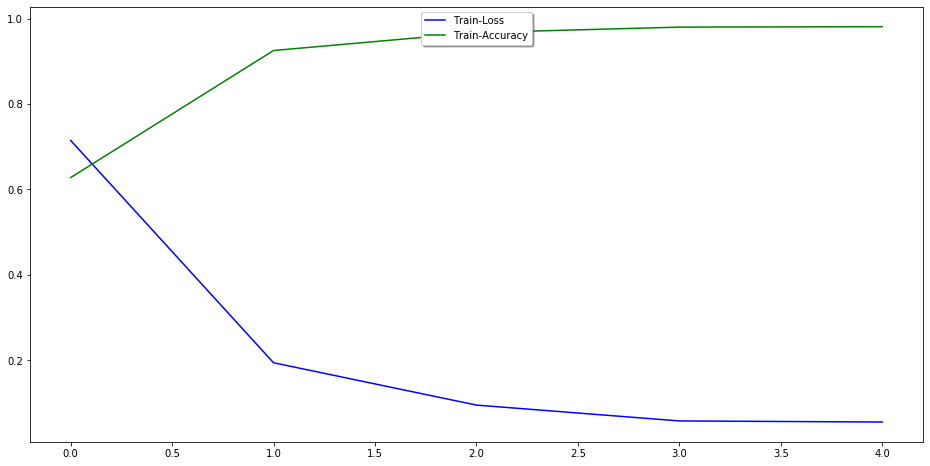

In [0]:
plt.plot(list(results.history.values())[0],'b',label='Train-Loss')
plt.plot(list(results.history.values())[1],'g',label='Train-Accuracy')
plt.legend(loc='upper center', shadow=True)

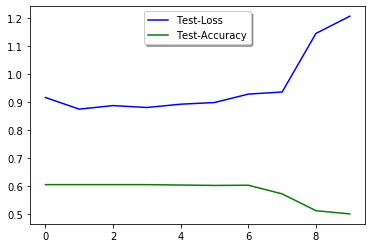

In [0]:
plt.plot(list(results.history.values())[2],'b',label='Test-Loss')
plt.plot(list(results.history.values())[3],'g',label='Test-Accuracy')
plt.legend(loc='upper center', shadow=True)

### Model 2.2 (Siyuan)
Conv32-Conv64-Conv128-Dense128 (image only)

In [0]:
# 3 Conv model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same',input_shape=(64,64, channels)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu',kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu',kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((9972, 192)))
model.add(Flatten())
model.add(Dense(128, activation='relu',kernel_initializer='he_uniform'))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

ValueError: ignored

In [0]:
es = callbacks.EarlyStopping(monitor='loss', mode='min')
results = model.fit(X_os, Ys,
         epochs=10,
         batch_size=64,
         
         )

ValueError: ignored

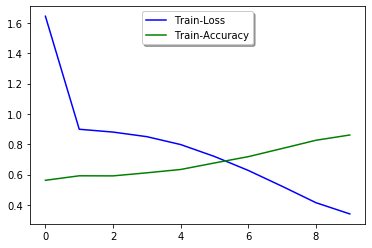

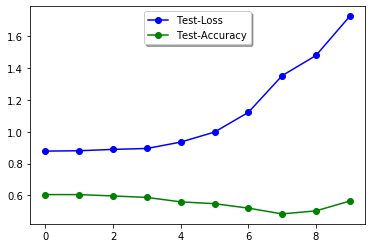

In [0]:
plt.plot(list(results.history.values())[0],'b',label='Train-Loss')
plt.plot(list(results.history.values())[1],'g',label='Train-Accuracy')
plt.legend(loc='upper center', shadow=True)
plt.show()
plt.plot(list(results.history.values())[2],'b-o',label='Test-Loss')
plt.plot(list(results.history.values())[3],'g-o',label='Test-Accuracy')
plt.legend(loc='upper center', shadow=True)
plt.show()

### Model 2.3 - CNN test

Conv32-Maxpool-Conv64-Maxpool-Dense128

In [0]:
# define model

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(width, height, channels)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
# model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.2))

model.add(Dense(3, activation='softmax'))

# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 62, 62, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 31, 31, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 61504)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)              

In [0]:
es = callbacks.EarlyStopping(monitor='loss', mode='min')
results = model.fit(X, Y,
         epochs=10,
         batch_size=64,
         shuffle=True,
        validation_split=0.2,
         callbacks=[es],
        class_weight=class_weights,
         )

Train on 5590 samples, validate on 1398 samples
Epoch 1/10
5590/5590 [==============================] - 3s 608us/sample - loss: 1.3174 - acc: 0.5782 - val_loss: 0.8743 - val_acc: 0.6052
Epoch 2/10
5590/5590 [==============================] - 3s 557us/sample - loss: 0.9040 - acc: 0.5921 - val_loss: 0.9005 - val_acc: 0.6052
Epoch 3/10
5590/5590 [==============================] - 3s 549us/sample - loss: 0.8947 - acc: 0.5921 - val_loss: 0.8999 - val_acc: 0.6052
Epoch 4/10
5590/5590 [==============================] - 3s 555us/sample - loss: 0.8838 - acc: 0.5943 - val_loss: 0.8863 - val_acc: 0.6030
Epoch 5/10
5590/5590 [==============================] - 3s 551us/sample - loss: 0.8615 - acc: 0.6030 - val_loss: 0.9031 - val_acc: 0.5937
Epoch 6/10
5590/5590 [==============================] - 3s 556us/sample - loss: 0.8315 - acc: 0.6161 - val_loss: 0.9105 - val_acc: 0.5758
Epoch 7/10
5590/5590 [==============================] - 3s 557us/sample - loss: 0.7822 - acc: 0.6426 - val_loss: 0.9737 - va

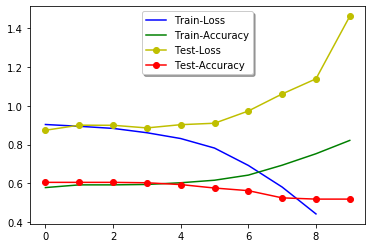

In [0]:
plt.plot(list(results.history.values())[0][1:],'b',label='Train-Loss')
plt.plot(list(results.history.values())[1],'g',label='Train-Accuracy')
plt.plot(list(results.history.values())[2],'y-o',label='Test-Loss')
plt.plot(list(results.history.values())[3],'r-o',label='Test-Accuracy')
plt.legend(loc='upper center', shadow=True)

### Prepare CapsuleNets

these module import codes may effect other non-capsule models. When you done training capsule models, please run the first code block "Import module" at the beginning

In [0]:
from __future__ import print_function
import tensorflow as tf
from keras import backend as K
from keras.layers import Layer
from keras import activations
from keras import utils
from keras.models import Model
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator

In [0]:
def squash(x, axis=-1):
    s_squared_norm = K.sum(K.square(x), axis, keepdims=True) + K.epsilon()
    scale = K.sqrt(s_squared_norm) / (0.5 + s_squared_norm)
    return scale * x
# define our own softmax function instead of K.softmax
# because K.softmax can not specify axis.
def softmax(x, axis=-1):
    ex = K.exp(x - K.max(x, axis=axis, keepdims=True))
    return ex / K.sum(ex, axis=axis, keepdims=True)

# define the margin loss like hinge loss
def margin_loss(y_true, y_pred):
    lamb, margin = 0.5, 0.1
    return K.sum(y_true * K.square(K.relu(1 - margin - y_pred)) + lamb * (
        1 - y_true) * K.square(K.relu(y_pred - margin)), axis=-1)
#     L = y_true * K.square(K.maximum(0., 0.9 - y_pred)) + 0.5 * (1 - y_true) * K.square(K.maximum(0., y_pred - 0.1))
#     return L

In [0]:
class Capsule(Layer):
    """A Capsule Implement with Pure Keras
    There are two vesions of Capsule.
    One is like dense layer (for the fixed-shape input),
    and the other is like timedistributed dense (for various length input).

    The input shape of Capsule must be (batch_size,
                                        input_num_capsule,
                                        input_dim_capsule
                                       )
    and the output shape is (batch_size,
                             num_capsule,
                             dim_capsule
                            )

    Capsule Implement is from https://github.com/bojone/Capsule/
    Capsule Paper: https://arxiv.org/abs/1710.09829
    """

    def __init__(self,
                 num_capsule,
                 dim_capsule,
                 routings=3,
                 share_weights=True,
                 activation='squash',
                 **kwargs):
        super(Capsule, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.share_weights = share_weights
        if activation == 'squash':
            self.activation = squash
        else:
            self.activation = activations.get(activation)

    def build(self, input_shape):
        input_dim_capsule = input_shape[-1]
        if self.share_weights:
            self.kernel = self.add_weight(
                name='capsule_kernel',
                shape=(1, input_dim_capsule,
                       self.num_capsule * self.dim_capsule),
                initializer='glorot_uniform',
                trainable=True)
        else:
            input_num_capsule = input_shape[-2]
            self.kernel = self.add_weight(
                name='capsule_kernel',
                shape=(input_num_capsule, input_dim_capsule,
                       self.num_capsule * self.dim_capsule),
                initializer='glorot_uniform',
                trainable=True)

    def call(self, inputs):
        """Following the routing algorithm from Hinton's paper,
        but replace b = b + <u,v> with b = <u,v>.

        This change can improve the feature representation of Capsule.

        However, you can replace
            b = K.batch_dot(outputs, hat_inputs, [2, 3])
        with
            b += K.batch_dot(outputs, hat_inputs, [2, 3])
        to realize a standard routing.
        """

        if self.share_weights:
            hat_inputs = K.conv1d(inputs, self.kernel)
        else:
            hat_inputs = K.local_conv1d(inputs, self.kernel, [1], [1])

        batch_size = K.shape(inputs)[0]
        input_num_capsule = K.shape(inputs)[1]
        hat_inputs = K.reshape(hat_inputs,
                               (batch_size, input_num_capsule,
                                self.num_capsule, self.dim_capsule))
        hat_inputs = K.permute_dimensions(hat_inputs, (0, 2, 1, 3)) #重新排序维度

        b = K.zeros_like(hat_inputs[:, :, :, 0])
        for i in range(self.routings):
            c = softmax(b, 1)
#             o = self.activation(K.batch_dot(c, hat_inputs, [2, 2]))
            o = self.activation(tf.keras.backend.batch_dot(c, hat_inputs, [2, 2]))
#             #新版的Keras batch_dot 的结果和原作者expected shape不同
            if i < self.routings - 1:
                b = tf.keras.backend.batch_dot(o, hat_inputs, [2, 3])
#                 b = K.batch_dot(o, hat_inputs, [2, 3])
        return o

    def compute_output_shape(self, input_shape):
        return (None, self.num_capsule, self.dim_capsule)

### Model 2.4 - CapsNet+Imgage
adapted from keras cifar10 model

In [0]:
batch_size = 64
epochs = 10
num_class = 3

# A common Conv2D model
input_image = Input(shape=(None, None, 3))
x = Conv2D(64, (3, 3), activation='relu')(input_image)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = AveragePooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = Conv2D(128, (3, 3), activation='relu')(x)


x = Reshape((-1, 128))(x)
capsule = Capsule(num_class, 32, 5, True)(x)
output = Lambda(lambda z: K.sqrt(K.sum(K.square(z), 2)))(capsule)
model = Model(inputs=input_image, outputs=output)

# we use a margin loss
model.compile(loss=margin_loss, optimizer='adam', metrics=['accuracy'])
# model.summary()

In [0]:
results = model.fit(
        X_os,
        Ys,
        batch_size=64,
        epochs=10        
)

ValueError: ignored

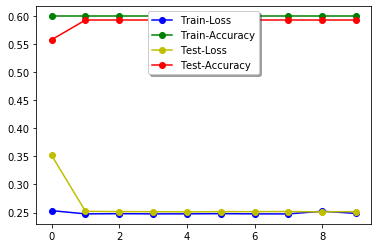

In [0]:
plt.plot(list(results.history.values())[0],'b-o',label='Train-Loss')
plt.plot(list(results.history.values())[1],'g-o',label='Train-Accuracy')
plt.legend(loc='upper center', shadow=True)
plt.plot(list(results.history.values())[2],'y-o',label='Test-Loss')
plt.plot(list(results.history.values())[3],'r-o',label='Test-Accuracy')
plt.legend(loc='upper center', shadow=True)

CapsNet + Image + Data Augmentation

In [0]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the data
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by dataset std
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in 0 to 180 degrees
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(trainX)

    # Fit the model on the batches generated by datagen.flow().
results = model.fit_generator(
        datagen.flow(trainX, trainY, batch_size=batch_size),
        epochs=epochs,
        validation_data=(testX, testY),
        workers=4)


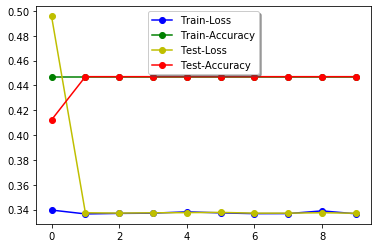

In [0]:
plt.plot(list(results.history.values())[0],'b-o',label='Train-Loss')
plt.plot(list(results.history.values())[1],'g-o',label='Train-Accuracy')
plt.legend(loc='upper center', shadow=True)
plt.plot(list(results.history.values())[2],'y-o',label='Test-Loss')
plt.plot(list(results.history.values())[3],'r-o',label='Test-Accuracy')
plt.legend(loc='upper center', shadow=True)

## Image + Text Fusion



In [0]:
#text data
print(padded_train.shape)
#image data
print(X.shape, Y.shape)

(6988, 192)
(6988, 128, 128, 3) (6988, 3)


#### Model 3.1 - Concat CNN+LSTM

In [98]:
np.random.seed(1)
tf.set_random_seed(2)
a = input_text = Input(shape = max_length)
a = Embedding(vocab_size, 100)(a)
# b = Dropout(0.2)(b)
a = LSTM(128, return_sequences=True)(a)
# b = Dropout(0.2)(b)
a = Flatten()(a)
a = Dense(3, activation='relu')(a)

b = input_img = Input(shape = (width, height, channels))
b = Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform')(b)
b = Dropout(0.2)(b)
b = MaxPooling2D((2,2))(b)
b = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform')(b)
b = MaxPooling2D((2,2))(b)
b = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform')(b)
b = MaxPooling2D((2,2))(b)
b = Flatten()(b)
b = Dense(128, activation='relu')(b)

combine = Concatenate(axis=-1,)([a,b])
combine = Dense(128, activation='relu')(combine)
output = Dense(2, activation='softmax')(combine)

Model_text_img_clr = Model([input_img,input_text],output)
Model_text_img_clr.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
Model_text_img_clr.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 128, 128, 32) 896         input_16[0][0]                   
__________________________________________________________________________________________________
dropout_7 (Dropout)             (None, 128, 128, 32) 0           conv2d_21[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_21 (MaxPooling2D) (None, 64, 64, 32)   0           dropout_7[0][0]                  
____________________________________________________________________________________________

In [99]:
results = Model_text_img_clr.fit([X,X_text], Y,
         epochs=10, 
         batch_size=64,
         shuffle=True,
        validation_split=0.2,
         class_weight=class_weights
         )

Train on 5590 samples, validate on 1398 samples
Epoch 1/10
5590/5590 [==============================] - 35s 6ms/sample - loss: 1.4105 - acc: 0.5945 - val_loss: 0.6698 - val_acc: 0.6166
Epoch 2/10
5590/5590 [==============================] - 34s 6ms/sample - loss: 0.6595 - acc: 0.6134 - val_loss: 0.6768 - val_acc: 0.6130
Epoch 3/10
5590/5590 [==============================] - 34s 6ms/sample - loss: 0.5258 - acc: 0.7512 - val_loss: 0.8472 - val_acc: 0.5358
Epoch 4/10
5590/5590 [==============================] - 33s 6ms/sample - loss: 0.2974 - acc: 0.8767 - val_loss: 0.9265 - val_acc: 0.5436
Epoch 5/10
5590/5590 [==============================] - 34s 6ms/sample - loss: 0.1326 - acc: 0.9526 - val_loss: 1.4410 - val_acc: 0.5343
Epoch 6/10
5590/5590 [==============================] - 34s 6ms/sample - loss: 0.0742 - acc: 0.9748 - val_loss: 1.8362 - val_acc: 0.5093
Epoch 7/10
5590/5590 [==============================] - 33s 6ms/sample - loss: 0.0497 - acc: 0.9841 - val_loss: 2.1095 - val_acc: 

In [100]:
Model_text_img_clr.evaluate([X_trial,X_text_trial], Y_trial)

910/910 [==============================] - 2s 3ms/sample - loss: 1.3480 - acc: 0.5066


[1.3479562824899023, 0.5065934]

In [106]:
temp = Model_text_img_clr.predict([X_trial,X_text_trial])
temp_pre = [np.argmax(i) for i in temp]
temp_truth = [np.argmax(i) for i in Y_trial]
print(accuracy_score(temp_pre, temp_truth),f1_score(temp_pre, temp_truth, average='macro'))

0.5065934065934066 0.49800906456134925


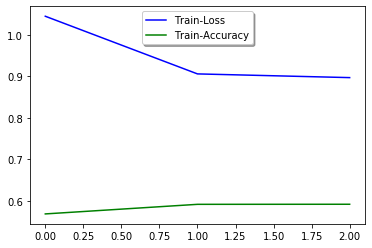

In [0]:
plt.plot(list(results.history.values())[0],'b',label='Train-Loss')
plt.plot(list(results.history.values())[1],'g',label='Train-Accuracy')
plt.legend(loc='upper center', shadow=True)

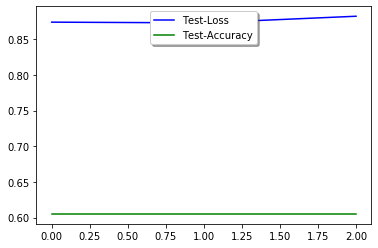

In [0]:
plt.plot(list(results.history.values())[2],'b',label='Test-Loss')
plt.plot(list(results.history.values())[3],'g',label='Test-Accuracy')
plt.legend(loc='upper center', shadow=True)

### Model 3.2 - CapsNet+Text+Img
Run the "Prepare CapsuleNets" block before training this model 

In [0]:
num_class = 5

t = input_text = Input(shape = (max_length,))
t = Embedding(vocab_size, 50)(t)
t = Dropout(0.2)(t)
t = CuDNNLSTM(64, return_sequences=True)(t)
t = Flatten()(t)

# t = Conv1D(128, 3, padding='valid', activation='relu', strides=1)(t)
# t = GlobalMaxPooling1D()(t)
# t = Dense(128, activation='relu')(t)

x = input_image = Input(shape=(width, height, channels))
t = Dropout(0.2)(t)
x = Conv2D(32, (3, 3), activation='relu')(x)
x = Conv2D(32, (3, 3), activation='relu')(x)
x = AveragePooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = Flatten()(x)

combine = Concatenate(axis=-1,)([t,x])
combine = Dense(128, activation='relu')(combine)
combine = Reshape((-1, 64))(combine)

capsule = Capsule(num_class, 16, 3, True)(combine)

output = Lambda(lambda z: K.sqrt(K.sum(K.square(z), 2)))(capsule)

Model6 = Model([input_text,input_image], output)
Model6.compile(loss=margin_loss, optimizer='adam', metrics=['accuracy'])
Model6.summary()

In [0]:
results = Model6.fit(
        [padded_train,X],
        Y,
        batch_size=64,
        epochs=10,
        validation_split=0.2,
#         validation_data=(testX, testY),
        shuffle=True,
#         class_weight=class_weights
)

# Manual Test

## Result Analysis

Not suitable for Img+text fusion models

In [0]:
def resultAnalysis(model, X_os, Ys): # you should use seperated test data
  y_pred = model.predict(X_test_Val_t)
  y_pred_cate = [np.argmax(i) for i in y_pred]
  print("Prediction classes count:\n",pd.Series(y_pred_cate).value_counts())
  y_truth = [np.argmax(i) for i in y_test_total1]
  print("\nTest classes count:\n",pd.Series(y_truth).value_counts())
  print(classification_report(y_truth,y_pred_cate))

In [0]:
resultAnalysis(model, X_os, Ys) # just a example, should use test set

# Load model and test data



In [0]:
import pickle 
X_test = pickle.load(open("/content/drive/My Drive/SemEval_2020/TestX.pickle", "rb"))
data_test = pickle.load(open("/content/drive/My Drive/SemEval_2020/TestData.pickle", "rb"))
# X = X/255

In [0]:
data_test.shape, X_test.shape,X_test.min(),X_test.max()

((1878, 4), (1877, 128, 128, 3), 0, 255)

In [0]:
def encodeText_test(orig_text):
  t = Tokenizer()
  X_text = [str(i) for i in orig_text]
  t.fit_on_texts(X_text)
  vocab_size = len(t.word_index) + 1
  encoded_train = t.texts_to_sequences(X_text)
  # max_length = max(list(map(lambda x: len(x), encoded_train)))
  padded_train = pad_sequences(encoded_train, maxlen=192, padding='post')
  return padded_train, vocab_size, max_length

In [0]:
padded_test, vocab_size, max_length = encodeText_test(data_test['corrected_text'])

In [0]:
padded_test.shape

(1878, 192)

In [0]:
prediction = model.predict(padded_test)

In [0]:
temp_pre = [np.argmax(i) for i in prediction]
pd.Series(temp_pre).value_counts()

1    1866
0      12
dtype: int64

In [0]:
# temp_pre.insert(0,0)
len(temp_pre)

1878

In [0]:
res = pd.DataFrame(temp_pre)
# res[1] = [9999 for i in range(len(res))]
# res[2] = [9999 for i in range(len(res))]
res = res.replace(0,'h').replace(1,0).replace('h',1)
res[0].value_counts()

1    1866
0      12
Name: 0, dtype: int64

In [0]:
res.shape

res.to_csv('task8B_o_balanced.csv',header=False,index=False,sep=',')
